## Single-image Grad-CAM with Mask Contour (SG-ResNet)

Device: cuda


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 170MB/s]


Loaded SG-ResNet weights from: /kaggle/input/segmentation-guided-resnet-34-model-outputs/ham_sg_resnet_outputs/best_sg_resnet_model.pth


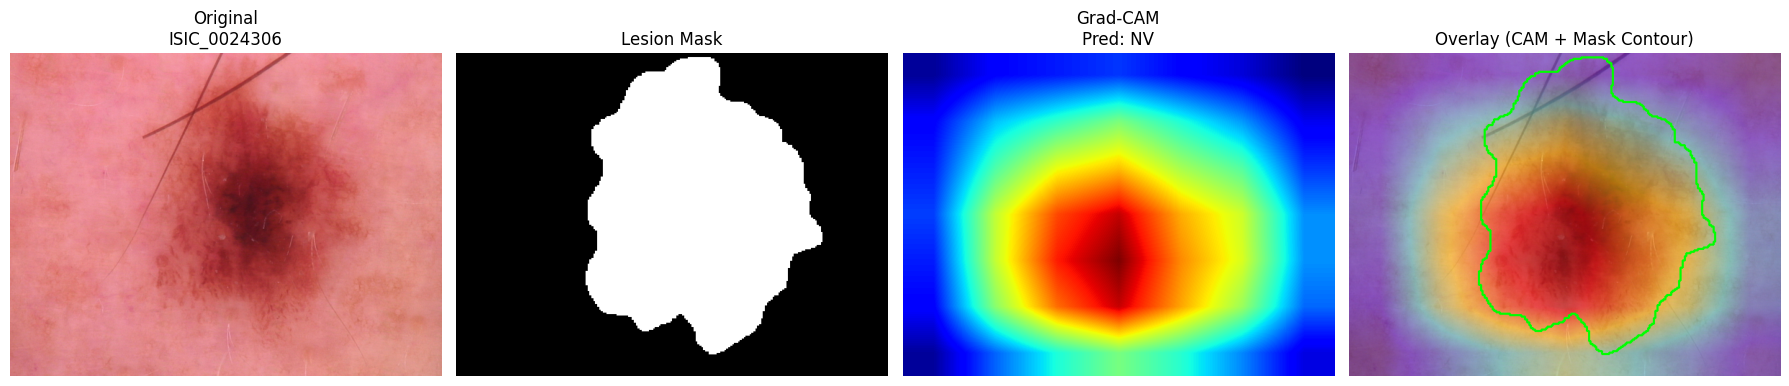

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2  # if missing: pip install opencv-python-headless

# ---------------- CONFIG ----------------
IMAGE_ID = "ISIC_0024306"  # <-- change to any image ID you want

IMAGES_DIR = Path("/kaggle/input/ham1000-segmentation-and-classification/images")
MASKS_DIR  = Path("/kaggle/input/ham1000-segmentation-and-classification/masks")

MODEL_PATH = Path("/kaggle/input/segmentation-guided-resnet-34-model-outputs/ham_sg_resnet_outputs/best_sg_resnet_model.pth")

CLASS_NAMES = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
NUM_CLASSES = len(CLASS_NAMES)

IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ------------- BUILD 4-CHANNEL SG-RESNET-34 (same as training) -------------
def build_4ch_resnet34(num_classes=7):
    resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

    old_conv = resnet.conv1
    new_conv = nn.Conv2d(
        in_channels=4,
        out_channels=old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=old_conv.bias is not None,
    )

    with torch.no_grad():
        new_conv.weight[:, :3, :, :] = old_conv.weight
        new_conv.weight[:, 3:4, :, :] = old_conv.weight.mean(dim=1, keepdim=True)

    resnet.conv1 = new_conv
    in_features = resnet.fc.in_features
    resnet.fc = nn.Linear(in_features, num_classes)
    return resnet

model = build_4ch_resnet34(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Loaded SG-ResNet weights from:", MODEL_PATH)

# ------------- TRANSFORMS -------------
img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# ------------- LOAD IMAGE + MASK & BUILD 4-CH INPUT -------------
def load_rgb_mask_4ch(image_id):
    img_path = IMAGES_DIR / f"{image_id}.jpg"
    mask_path = MASKS_DIR / f"{image_id}_segmentation.png"

    img_pil = Image.open(img_path).convert("RGB")

    img_t = img_transform(img_pil)  # (3,H,W)

    if mask_path.exists():
        mask_pil = Image.open(mask_path).convert("L")
        mask_pil = mask_pil.resize((IMG_SIZE, IMG_SIZE), resample=Image.NEAREST)
        mask_np = np.array(mask_pil)
        mask_bin = (mask_np > 0).astype("float32")
    else:
        mask_bin = np.zeros((IMG_SIZE, IMG_SIZE), dtype="float32")

    mask_t = torch.from_numpy(mask_bin).unsqueeze(0)  # (1,H,W)
    x_4ch = torch.cat([img_t, mask_t], dim=0).unsqueeze(0).to(DEVICE)  # (1,4,H,W)

    return img_pil, mask_bin, x_4ch

# ------------- GRAD-CAM IMPLEMENTATION -------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out.detach()

    def _save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, x_4ch, class_idx=None):
        self.model.zero_grad()
        logits = self.model(x_4ch)

        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        score = logits[0, class_idx]
        score.backward()

        grads = self.gradients      # (1,C,H,W)
        acts  = self.activations    # (1,C,H,W)

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1).squeeze(0)

        cam = F.relu(cam)
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()

        return cam.cpu().numpy(), class_idx

target_layer = model.layer4
gradcam = GradCAM(model, target_layer)

# ------------- RUN GRAD-CAM FOR ONE IMAGE -------------
img_pil, mask_resized_small, x_4ch = load_rgb_mask_4ch(IMAGE_ID)
cam, pred_idx = gradcam.generate(x_4ch, class_idx=None)
pred_class = CLASS_NAMES[pred_idx]

# ------------- BUILD OVERLAY WITH MASK CONTOUR -------------
# base RGB (original size)
img_np = np.array(img_pil).astype(np.float32) / 255.0
h, w, _ = img_np.shape

# resize CAM to original size
cam_resized = cv2.resize(cam, (w, h))
heatmap_color = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0

overlay = 0.4 * heatmap_color + 0.6 * img_np
overlay = np.clip(overlay, 0, 1)

# resize mask to original size
mask_resized = cv2.resize(mask_resized_small, (w, h), interpolation=cv2.INTER_NEAREST)
mask_binary = (mask_resized > 0.5).astype(np.uint8) * 255

# find contours on mask
contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# draw contours in green on overlay
overlay_with_contour = (overlay * 255).astype(np.uint8).copy()
cv2.drawContours(overlay_with_contour, contours, -1, (0, 255, 0), thickness=2)

# ------------- PLOT: Original, Mask, CAM, Overlay+Contour -------------
plt.figure(figsize=(18,4))

plt.subplot(1,4,1)
plt.imshow(img_pil)
plt.title(f"Original\n{IMAGE_ID}")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_resized, cmap="gray")
plt.title("Lesion Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(cam_resized, cmap="jet")
plt.title(f"Grad-CAM\nPred: {pred_class}")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(overlay_with_contour)
plt.title("Overlay (CAM + Mask Contour)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Run Grad-CAM + contour for multiple images and save

In [2]:
import os
import random

OUTPUT_DIR = Path("/kaggle/working/sg_resnet_gradcam_batch")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# list of available IDs (from GroundTruth.csv or images folder)
all_ids = [p.stem for p in IMAGES_DIR.glob("*.jpg")]

def save_gradcam_with_contour(image_id):
    img_pil, mask_small, x_4ch = load_rgb_mask_4ch(image_id)
    cam, pred_idx = gradcam.generate(x_4ch)
    pred_class = CLASS_NAMES[pred_idx]

    img_np = np.array(img_pil).astype(np.float32) / 255.0
    h, w, _ = img_np.shape

    cam_resized = cv2.resize(cam, (w, h))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0
    overlay = 0.4 * heatmap_color + 0.6 * img_np
    overlay = np.clip(overlay, 0, 1)

    mask_resized = cv2.resize(mask_small, (w, h), interpolation=cv2.INTER_NEAREST)
    mask_binary = (mask_resized > 0.5).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay_with_contour = (overlay * 255).astype(np.uint8).copy()
    cv2.drawContours(overlay_with_contour, contours, -1, (0, 255, 0), thickness=2)

    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs[0].imshow(img_pil); axs[0].set_title(f"Original\n{image_id}"); axs[0].axis("off")
    axs[1].imshow(mask_resized, cmap="gray"); axs[1].set_title("Mask"); axs[1].axis("off")
    axs[2].imshow(cam_resized, cmap="jet"); axs[2].set_title(f"Grad-CAM\n{pred_class}"); axs[2].axis("off")
    axs[3].imshow(overlay_with_contour); axs[3].set_title("Overlay + Contour"); axs[3].axis("off")

    plt.tight_layout()
    out_path = OUTPUT_DIR / f"{image_id}_sgresnet_gradcam.png"
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close()
    print("Saved:", out_path)

# generate for 5 random images
for _ in range(5):
    img_id = random.choice(all_ids)
    save_gradcam_with_contour(img_id)

Saved: /kaggle/working/sg_resnet_gradcam_batch/ISIC_0030414_sgresnet_gradcam.png
Saved: /kaggle/working/sg_resnet_gradcam_batch/ISIC_0031704_sgresnet_gradcam.png
Saved: /kaggle/working/sg_resnet_gradcam_batch/ISIC_0027345_sgresnet_gradcam.png
Saved: /kaggle/working/sg_resnet_gradcam_batch/ISIC_0027825_sgresnet_gradcam.png
Saved: /kaggle/working/sg_resnet_gradcam_batch/ISIC_0032538_sgresnet_gradcam.png


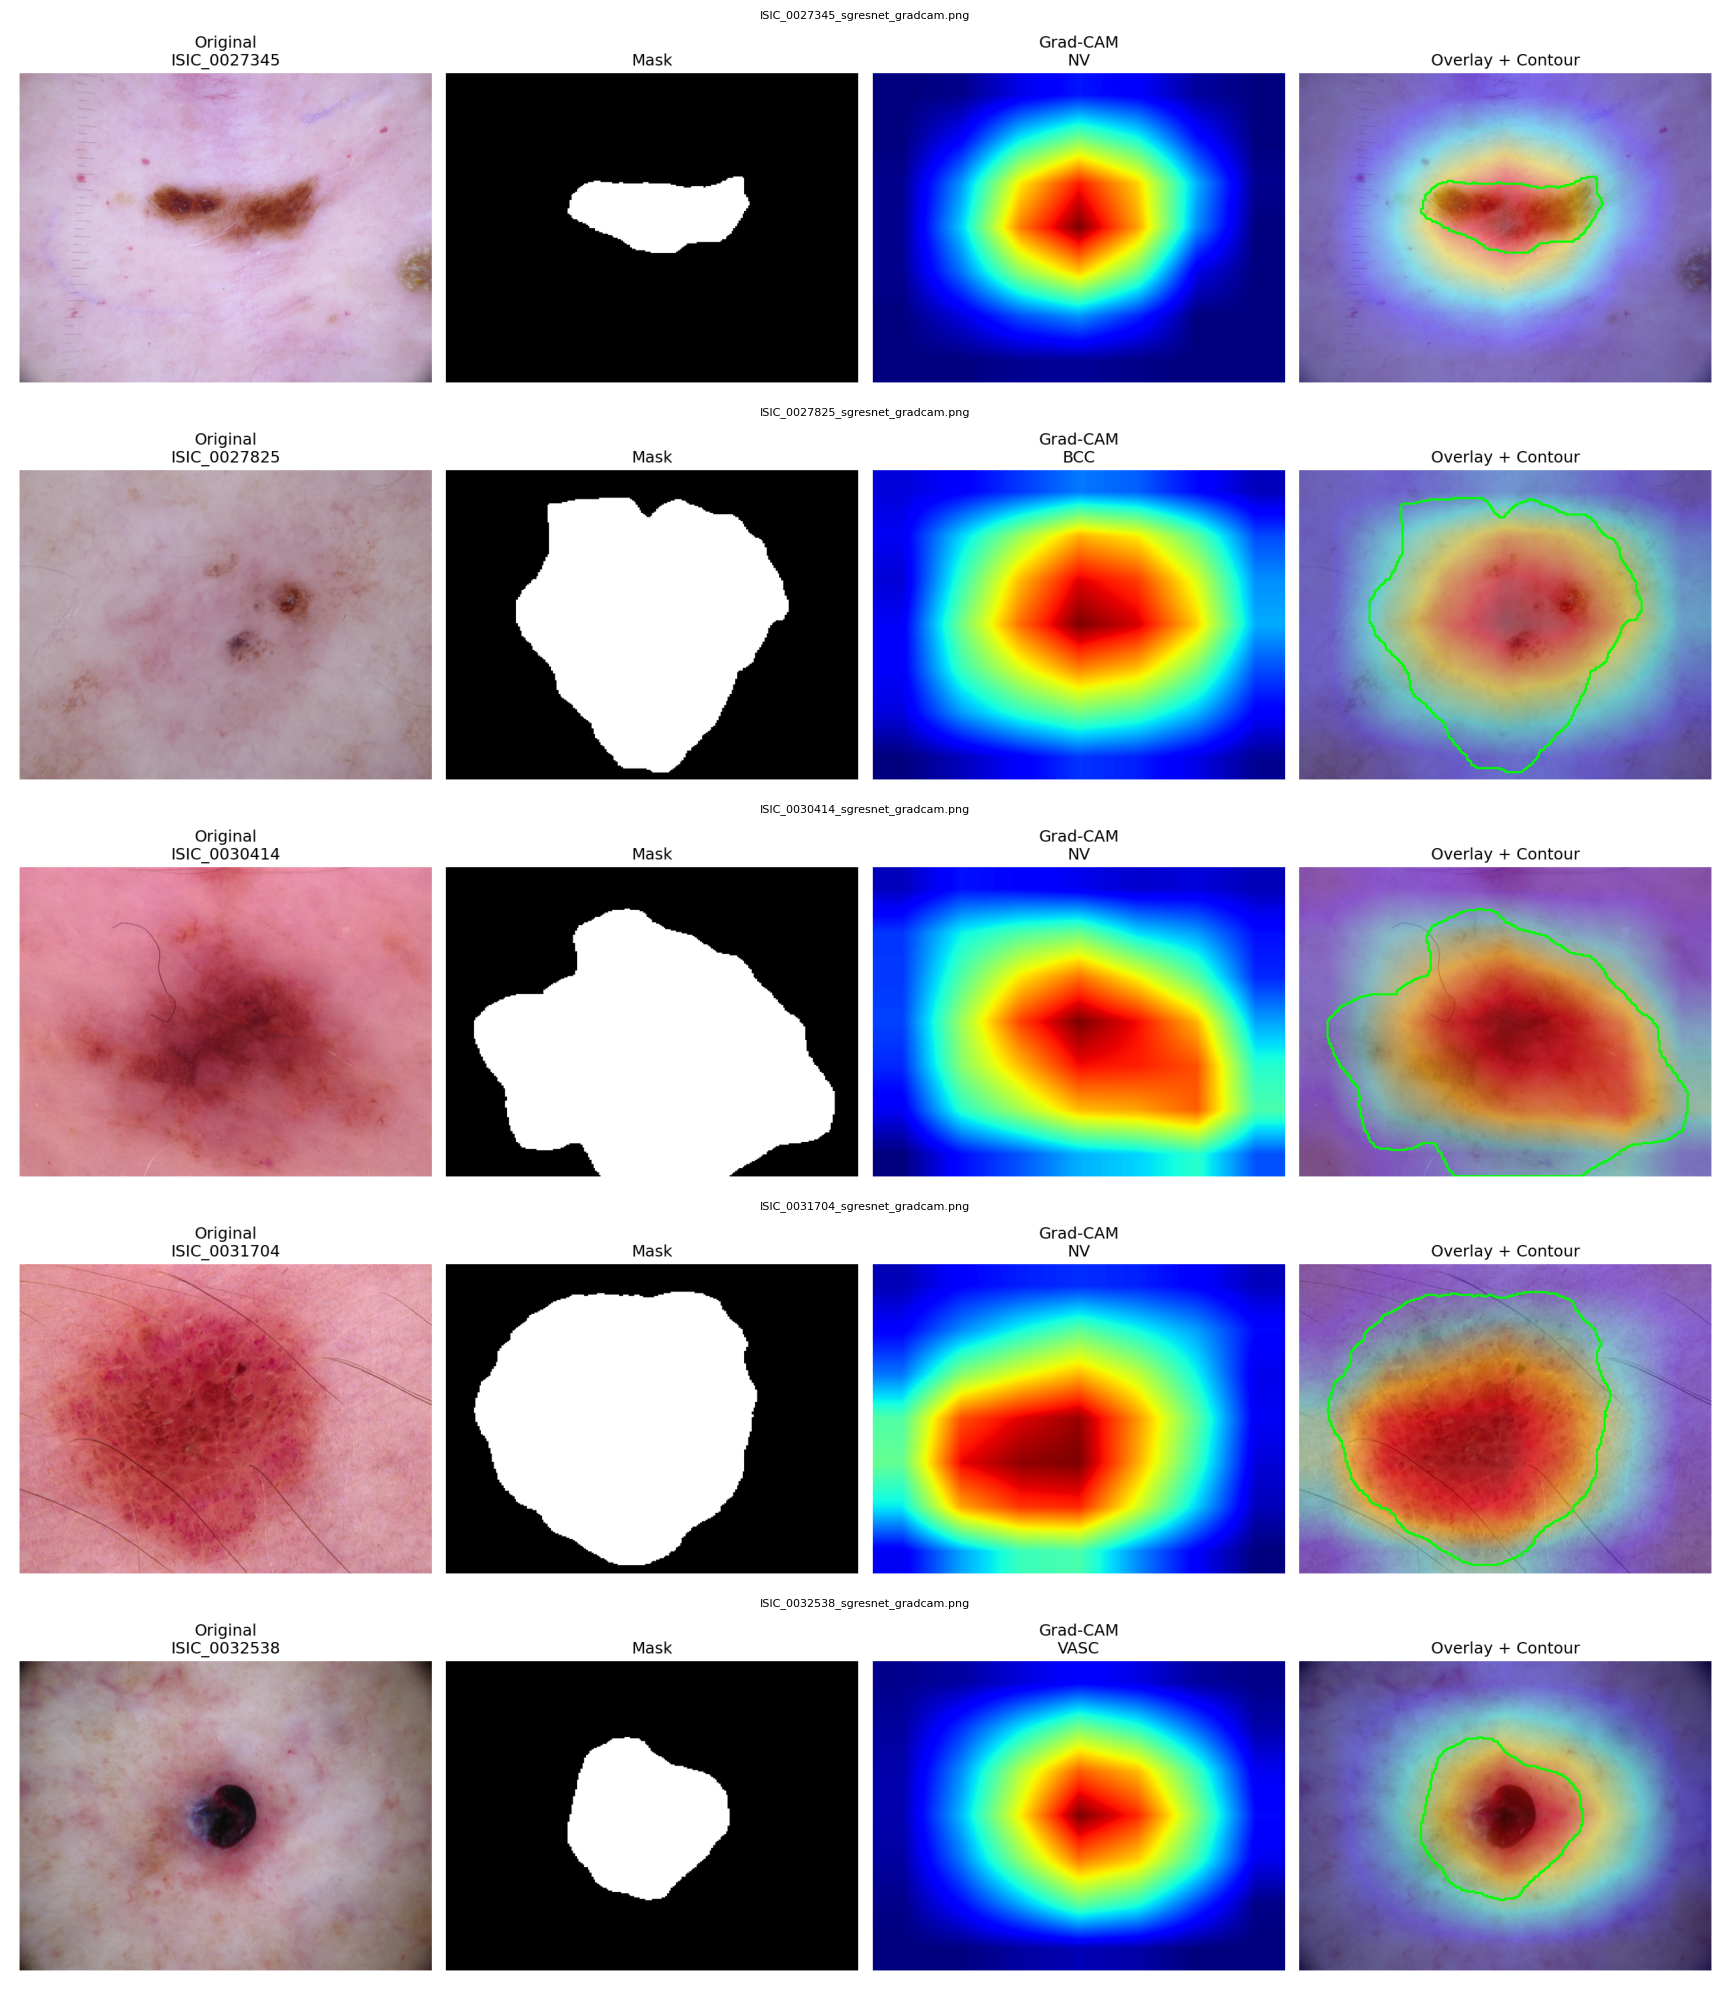

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Folder path
folder_path = '/kaggle/working/sg_resnet_gradcam_batch'

# Get list of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp'))]

# Sort files for consistent order
image_files.sort()

# Check if there are images
if not image_files:
    print("No image files found in the specified folder.")
else:
    # Determine grid size
    num_images = len(image_files)
    cols = 1  # Number of columns in the grid
    rows = (num_images + cols - 1) // cols  # Calculate rows needed

    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(100, 4 * rows))
    axes = axes.flatten()

    # Plot each image
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(img_file, fontsize=8)
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()